### **Install and import library**

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.2 MB/s 
     |████████████████████████████████| 182 kB 75.7 MB/s 
     |████████████████████████████████| 7.6 MB 46.8 MB/s 


In [2]:
pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 33.1 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645950 sha256=a31a507cbde62c5de01fb8e5bd38030bc246a53b58b2f7f6ef0191bb3cbfeb91
  Stored in directory: /root/.cache/pip/wheels/3c/e9/86/706911c12e307aeb9a2702399f0dad38d36f1d6f9dde8af35e
Successfully built vncorenlp


In [3]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2022-12-19 14:11:36--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.09s   

2022-12-19 14:11:38 (304 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2022-12-19 14:11:38--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [4]:
from google.colab import drive
import os
import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vncorenlp import VnCoreNLP
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

### **Connect to Google Drive**

In [5]:
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
DIR_ROOT = '/gdrive/MyDrive/FakeCommentDetection'
DIR_DATASET = os.path.join(DIR_ROOT, 'dataset')
DIR_COMMENT_DATASET = os.path.join(DIR_ROOT, 'data_merge.csv')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')
PATH_TEST = os.path.join(DIR_DATASET, 'test.csv')

STOPWORDS_PATH = os.path.join(DIR_ROOT, 'vietnamese-stopwords-dash.txt')

MODEL_DIR = os.path.join(DIR_ROOT, 'transformer_model')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [7]:
labels_task_2 = ["no-spam", "spam-1", "spam-2", "spam-3"]

def show_predict_result(trainer, test_dataset, y_test, labels):
    y_pred_classify = trainer.predict(test_dataset)
    y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index = labels, columns = labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### **Load data**

In [8]:
train_data = pd.read_csv(PATH_TRAIN)
X_train = train_data.iloc[:, 0:2]
y_train = train_data.iloc[:, 2:4]

dev_data = pd.read_csv(PATH_DEV)
X_dev = dev_data.iloc[:, 0:2]
y_dev = dev_data.iloc[:, 2:4]

test_data = pd.read_csv(PATH_TEST)
X_test = test_data.iloc[:, 0:2]
y_test = test_data.iloc[:, 2:4]

In [9]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [10]:
with open(STOPWORDS_PATH, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [11]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text


def pre_process_features(X, y1, y2, tokenized=True, lowercased=True):
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y1, idx)
            np.delete(y2, idx)
    return X, y1, y2

In [12]:
train_X, train_y, train_y_spam = pre_process_features(X_train['Comment'], y_train['Label'], y_train['SpamLabel'], tokenized=True, lowercased = False)
dev_X, dev_y, dev_y_spam = pre_process_features(X_dev['Comment'], y_dev['Label'], y_dev['SpamLabel'], tokenized=True, lowercased = False)
test_X, test_y, test_y_spam = pre_process_features(X_test['Comment'], y_test['Label'], y_test['SpamLabel'], tokenized=True, lowercased = False)

### **PhoBERT**

#### **Task 1**

In [13]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 4)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y_spam)
dev_dataset = BuildDataset(dev_encodings, dev_y_spam)
test_dataset = BuildDataset(test_encodings, test_y_spam)

OUTPUT_DIR = os.path.join(MODEL_DIR, 'phobert', 'task_2')

training_args = TrainingArguments(
    output_dir= OUTPUT_DIR,          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model(OUTPUT_DIR)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14306
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1790
  Number of trainable parameters = 135001348


Step,Training Loss
500,0.616200
1000,0.391600
1500,0.302400


Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/checkpoint-500
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/checkpoint-500/config.json
Model weights saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/checkpoint-1000
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/checkpoint-1000/config.json
Model weights saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/checkpoint-1500
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/checkpoint-1500/config.json
Model weights saved in /gdrive/MyDrive/FakeComm

***** Running Prediction *****
  Num examples = 3974
  Batch size = 16


F1 - micro: 0.8945646703573226
F1 - macro: 0.7494754609344276
Accuracy: 0.8945646703573226


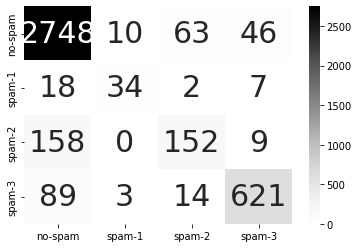

In [15]:
show_predict_result(trainer, test_dataset, test_y_spam, labels_task_2)

### **Detect Spam Review**

In [16]:
OUTPUT_DIR = os.path.join(MODEL_DIR, 'phobert', 'task_2')
args = TrainingArguments(disable_tqdm=True, output_dir="trained_trainer", log_level = 'warning')
trained_model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR, local_files_only=True)
trained_trainer = Trainer(model = trained_model, args = args)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2/config.json
Model config RobertaConfig {
  "_name_or_path": "/gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_2",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0"

In [17]:
import pandas as pd
import json
import ast
import numpy as np

In [18]:
df = pd.read_csv(DIR_COMMENT_DATASET)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
df['Reviews'] = df['Reviews'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else x)

In [20]:
df['Reviews']

0        [{'Usernames': 'Thao Pham', 'Date': '30/6/2022...
1        [{'Usernames': 'Ngọc Lê', 'Date': '22/2/2021 1...
2        [{'Usernames': 'Thiện Ngô', 'Date': '18/8/2022...
3        [{'Usernames': 'QuangHieu', 'Date': '24/11/202...
4        [{'Usernames': 'Lam Vuong', 'Date': '7/4/2022 ...
                               ...                        
18212    [{'Usernames': 'Duy', 'Date': '20/5/2021 18:26...
18213    [{'Usernames': 'Suri', 'Date': '13/8/2022 10:4...
18214    [{'Usernames': 'Bánh Canh An Nhiên', 'Date': '...
18215    [{'Usernames': 'Trang Thanh', 'Date': '27/9/20...
18216    [{'Usernames': 'Thinh Yokyta', 'Date': '24/2/2...
Name: Reviews, Length: 18217, dtype: object

In [21]:
def predict(trainer, datas):
  preproces_datas = [preprocess(p) for p in datas if len(preprocess(p))]
  fake_y = [0 for _ in range(len(preproces_datas))]
  datas_encoding = tokenizer(preproces_datas, truncation=True, padding=True, max_length = 100)
  test_dataset = BuildDataset(datas_encoding, fake_y)
  y_pred_classify = trainer.predict(test_dataset)
  y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
  return y_pred

In [22]:
def seedingPercent(trainer, cmts):
  if not isinstance(cmts, list):
    return cmts
    
  cmts_body = [p['Body'] for p in cmts if len(p['Body'])]

  if len(cmts_body):
    y_pred = predict(trainer, cmts_body)
    return y_pred
  else:
    return []

In [ ]:
df['Predict'] = df['Reviews'].apply(lambda x: seedingPercent(trained_trainer, x) if isinstance(x, list) else x)

In [ ]:
def getLen(x):
  if isinstance(x, float):
    return x
  
  x = x.tolist()
  return len(x)

In [ ]:
def getLenReviews(x):
  if isinstance(x, float):
    return x

  reviews = [p['Body'] for p in x if len(p['Body'])]
  return len(reviews)

In [ ]:
def seedingPercent(x):
  try:
    if isinstance(x['Reviews'], float):
      return x['Reviews']
  except:
    print(x['lenReview'])
  
  if x['lenReview'] == 0:
    return 0
  
  return round(x['Predict'].count(3) / x['lenReview'], 2)

In [ ]:
df['lenPredict'] = df['Predict'].apply(getLen)
df['lenReview'] = df['Reviews'].apply(getLenReviews)

In [ ]:
df['seedingPercent'] = df.apply(seedingPercent, axis = 1)

In [ ]:
df = df.drop(columns = ['Predict', 'lenPredict', 'lenReview'])